In [121]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters
import skimage.transform as tf
from skimage.feature import match_template
%matplotlib inline

def plot_img(img, cmap='gray'):
    #plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [3]:
def remove_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sobel_mag = np.sqrt(sum([filters.sobel(gray, axis=i)**2
                             for i in range(gray.ndim)]) / gray.ndim)
    bin_sobel_mag  = sobel_mag > 0.1

    kernel1 = np.ones((3, 3), 'uint8')
    kernel2 = np.ones((7, 7), 'uint8')

    erode_img = bin_sobel_mag.astype('uint8')
    dilate_img = cv2.dilate(erode_img, kernel2, iterations=1)

    contours, hierarchy = cv2.findContours(dilate_img.astype('uint8'), cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(cnt) for cnt in contours]

    index = np.argmax(areas)

    rect = cv2.minAreaRect(contours[index])

    box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
    box = np.int0(box)
    distances = [np.linalg.norm(point) for point in box]
    if np.argmin(distances) == 1:
        box = box[[1, 2, 3, 0]]
    w = np.sqrt(np.sum((box[1] - box[0])**2))
    h = np.sqrt(np.sum((box[2] - box[1])**2))

    w = int(w)
    h = int(h)

    src = np.array([[0, 0], [0, w], [h, w], [h, 0]])
    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, box)
    result_table = tf.warp(img, tform3, output_shape=(w, h))

    #plt.imshow(result_table)
    
    return result_table

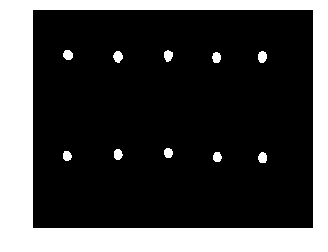

10


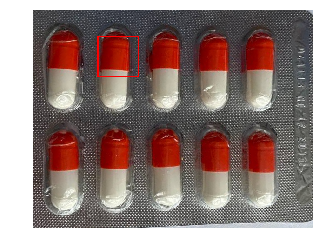

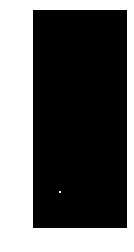

1


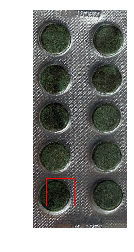

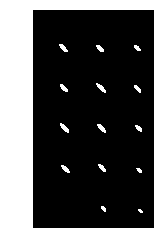

14


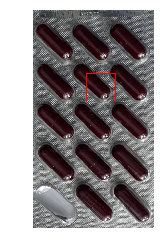

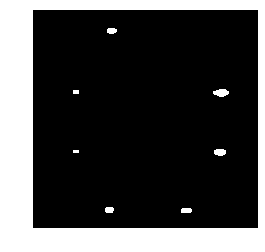

7


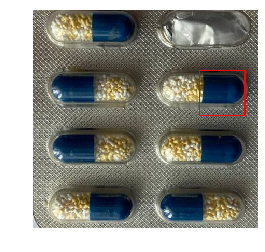

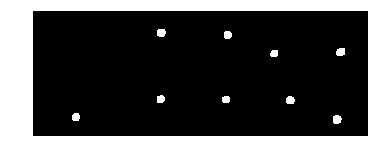

9


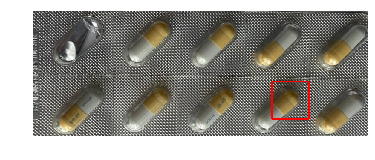

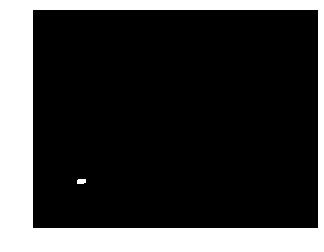

1


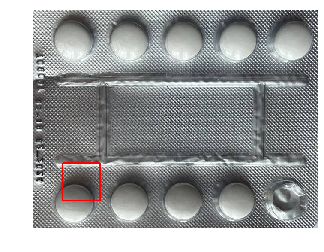

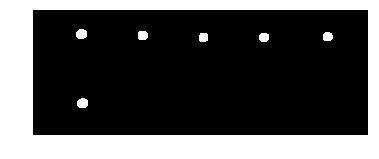

6


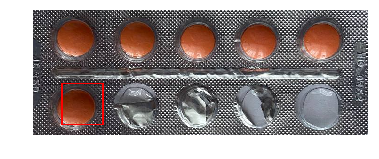

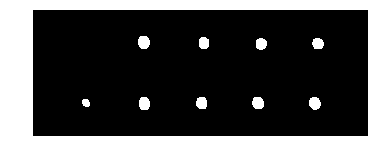

9


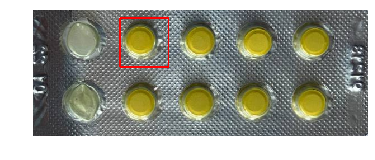

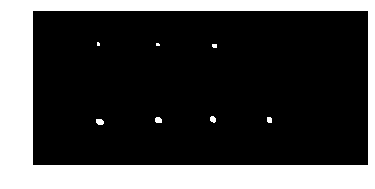

7


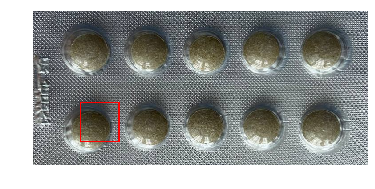

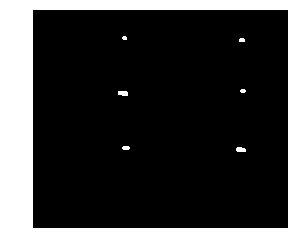

6


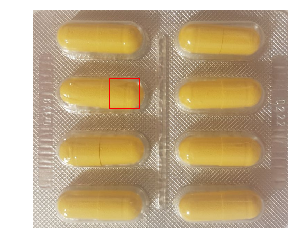

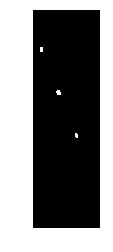

3


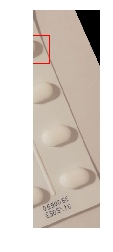

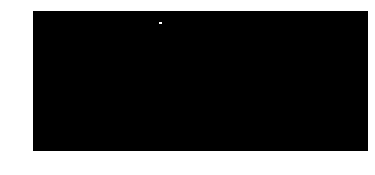

1


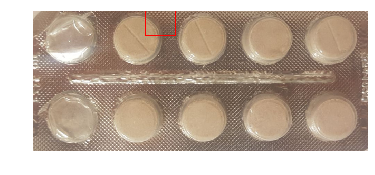

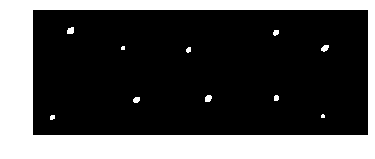

10


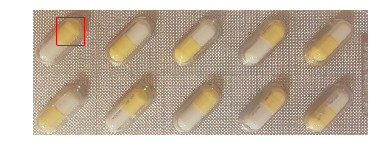

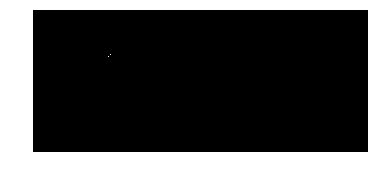

2


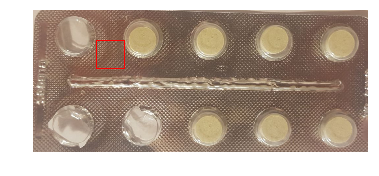

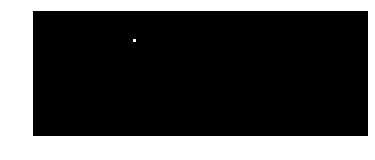

1


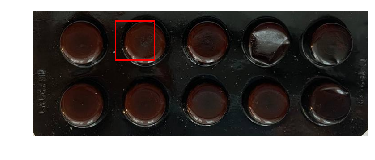

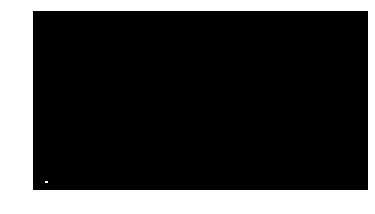

1


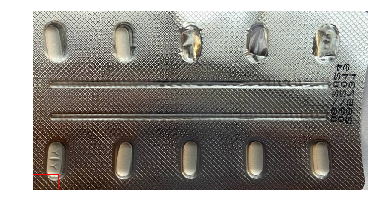

In [340]:
for file in ['01', '02', '03', '04', '05', '06', '07', '08',
     '09', '10', '11', '12', '13', '14', '15', '16']:
    img = cv2.imread('pills/pills/'+file+'.jpg')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    table = remove_edges(img_rgb)[20:-20, 20:-20]
    
    #plot_img(table)
    table = (table * 255).astype('uint8')
    hsv = cv2.cvtColor(table, cv2.COLOR_RGB2HSV)
    #plot_img(hsv[:,:,1])
    
    radius = 73
    hsv = hsv[:,:,1]
    hsv_blur = cv2.GaussianBlur(hsv, (radius, radius), 0)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(hsv_blur)
    
    cv2.rectangle(table, (maxLoc[0] - radius // 2, maxLoc[1] - radius // 2), 
                         (maxLoc[0] + int(radius * 0.7), maxLoc[1] + int(radius * 0.7)), (255, 0, 0), 2)
    # display the results of our newly improved method
    #plot_img(table)
    
    
    x_min = maxLoc[0] - radius // 2
    y_min = maxLoc[1] - radius // 2
    x_max = maxLoc[0] + int(radius * 0.7)
    y_max = maxLoc[1] + int(radius * 0.7)

    if y_min < 0:
        y_min = 0
    if x_min < 0:
        x_min = 0

    template = hsv[y_min:y_max, x_min:x_max]
    corr_skimage = match_template(hsv, template, pad_input=True)
    treshold = (corr_skimage > 0.8).astype('uint8')
    #plot_img(treshold)
    
    kernel = np.ones((5, 5), np.uint8)
    #opening = cv2.morphologyEx(treshold, cv2.MORPH_OPEN, kernel)
    dilation = cv2.dilate(treshold, kernel, iterations = 1)

    plot_img(dilation)
    ret, labels = cv2.connectedComponents(dilation)
    
    print(ret - 1)
    plot_img(table)

In [288]:
img = cv2.imread('pills/pills/01.jpg')[20:-20, 20:-20]
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [289]:
table = remove_edges(img_rgb)

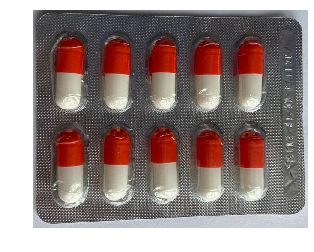

In [290]:
plot_img(table)

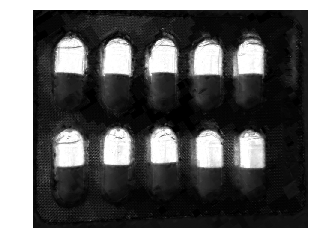

In [291]:
table = (table * 255).astype('uint8')
hsv = cv2.cvtColor(table, cv2.COLOR_RGB2HSV)
plot_img(hsv[:,:,1])
hsv = hsv[:,:,1]

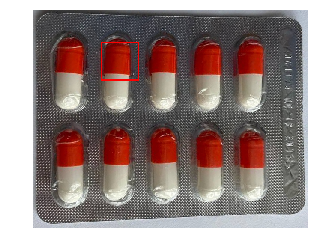

In [292]:
# apply a Gaussian blur to the image then find the brightest
# region
radius = 73
hsv_blur = cv2.GaussianBlur(hsv, (radius, radius), 0)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(hsv_blur)
#cv2.circle(table, maxLoc, radius, (255, 0, 0), 2)
cv2.rectangle(table, (maxLoc[0] - radius // 2, maxLoc[1] - radius // 2), 
                      (maxLoc[0] + int(radius * 0.7), maxLoc[1] + int(radius * 0.7)), (255, 0, 0), 2)
# display the results of our newly improved method
#cv2.imshow("Robust", table)
plot_img(table)

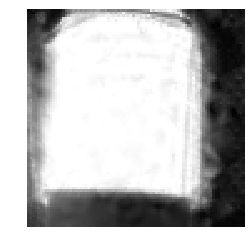

In [293]:
x_min = maxLoc[0] - radius // 2
y_min = maxLoc[1] - radius // 2
x_max = maxLoc[0] + int(radius * 0.7)
y_max = maxLoc[1] + int(radius * 0.7)

if y_min < 0:
    y_min = 0
if x_min < 0:
    x_min = 0

template = hsv[y_min:y_max, x_min:x_max]
plot_img(template)

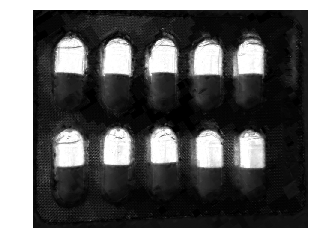

In [294]:
plot_img(hsv)

In [295]:
corr_skimage = match_template(hsv, template, pad_input=True)

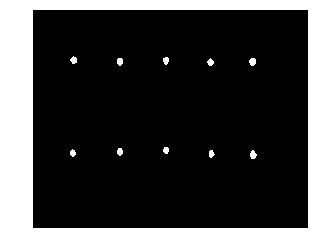

In [296]:
treshold = (corr_skimage > 0.8).astype('uint8')
plot_img(treshold)

In [326]:
#ret, labels = cv2.connectedComponents(treshold)
kernel = np.ones((10, 10), np.uint8)
erosion = cv2.erode(treshold, kernel, iterations = 1)

kernel = np.ones((30, 30), np.uint8)
dilation = cv2.dilate(erosion, kernel,iterations = 1)
#opening = cv2.morphologyEx(treshold, cv2.MORPH_OPEN, kernel)

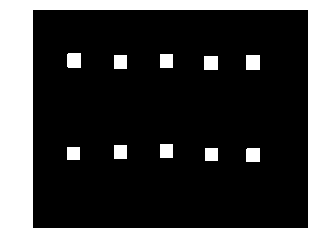

In [327]:
plot_img(dilation)

In [333]:
ret, labels = cv2.connectedComponents(dilation)
ret

11

In [334]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

In [216]:
#table_top = table[table.shape[0] // 2:, :]
#table_bottom = table[:table.shape[0] // 2+1, :]
#difference = table_top - table_bottom
#plot_img(difference)